In [8]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'image-super-resolution-from-unsplash:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2548969%2F4328365%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240422%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240422T071317Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da6c2bf2a4092559ea3dfcf860b42e3bc59b06d1097d300afdcf5d3fe12d62a3493556db22c3d8c3cfd6c95674e81a2c7d888404543043a53e3c980dfd610c54a5a7df04eb250fab3922b8f9e7f1f07e711c856e6a21e97d4ca639a8388985a8a031a35503d9d1df699e28cdc860fcc9fd71d360826833eb19dab1ed19a77015a34e3af06bd89e1be73a7eb7e31cd0fa70922969cdc4125d981bdecd7d20c7deec24455d274c7a832f96f2ddaa5f1a76a43111da79710d8a718e17fbcd4f1ed41c80e55994b799613e6c33ad25b4ccca43260d19e7a2988c5030cee3f501e80bf51a0fc157bcc21fc063d65178a99d06e68d6f0194828ed8a3be4b6c600d0e9ff'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1040966612 bytes downloaded
Downloaded and uncompressed: image-super-resolution-from-unsplash
Data source import complete.


In [11]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install --upgrade tensorflow


In [5]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [12]:
base_directory = '../input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash'
hires_folder = os.path.join(base_directory, 'high res')
lowres_folder = os.path.join(base_directory, 'low res')

In [13]:
data = pd.read_csv("../input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/image_data.csv")
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowres_folder,x))
data['high_res'] = data['high_res'].apply(lambda x: os.path.join(hires_folder,x))
data.head()

,low_res,high_res
0,../input/image-super-resolution-from-unsplash/...,../input/image-super-resolution-from-unsplash/...
1,../input/image-super-resolution-from-unsplash/...,../input/image-super-resolution-from-unsplash/...
2,../input/image-super-resolution-from-unsplash/...,../input/image-super-resolution-from-unsplash/...
3,../input/image-super-resolution-from-unsplash/...,../input/image-super-resolution-from-unsplash/...
4,../input/image-super-resolution-from-unsplash/...,../input/image-super-resolution-from-unsplash/...


In [14]:
batch_size = 4

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_hiresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='high_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='training')

train_lowresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='low_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='training')

val_hiresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='high_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='validation')

val_lowresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='low_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='validation')

train_generator = zip(train_lowresimage_generator, train_hiresimage_generator)
val_generator = zip(val_lowresimage_generator, val_hiresimage_generator)

def imageGenerator(train_generator):
    for (low_res, hi_res) in train_generator:
            yield (low_res, hi_res)

Found 3198 validated image filenames.
Found 3198 validated image filenames.
Found 564 validated image filenames.
Found 564 validated image filenames.


# Data Visualization


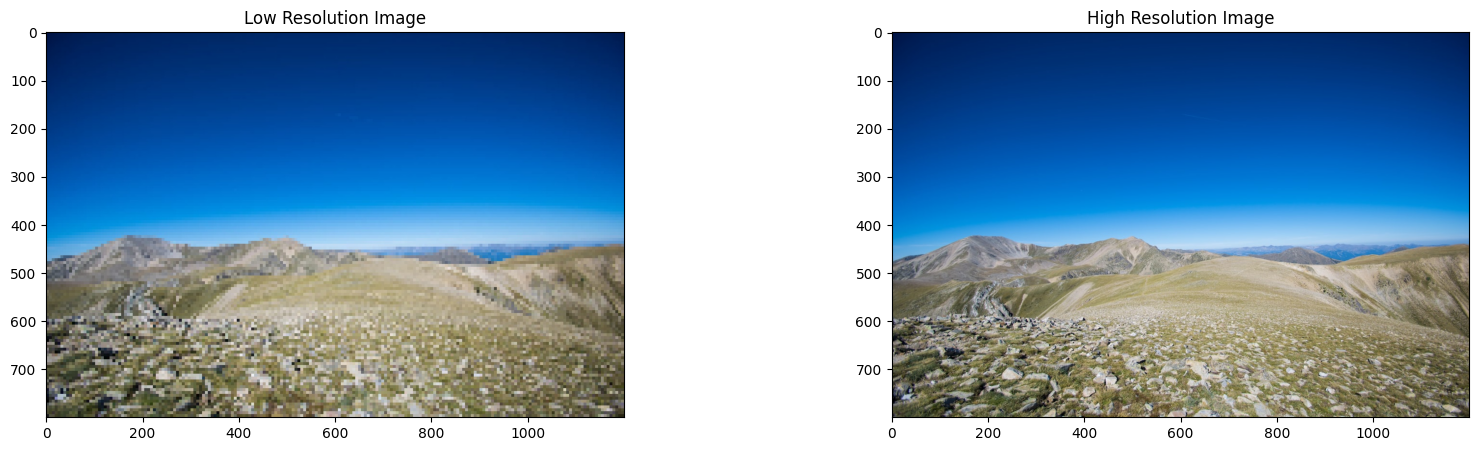

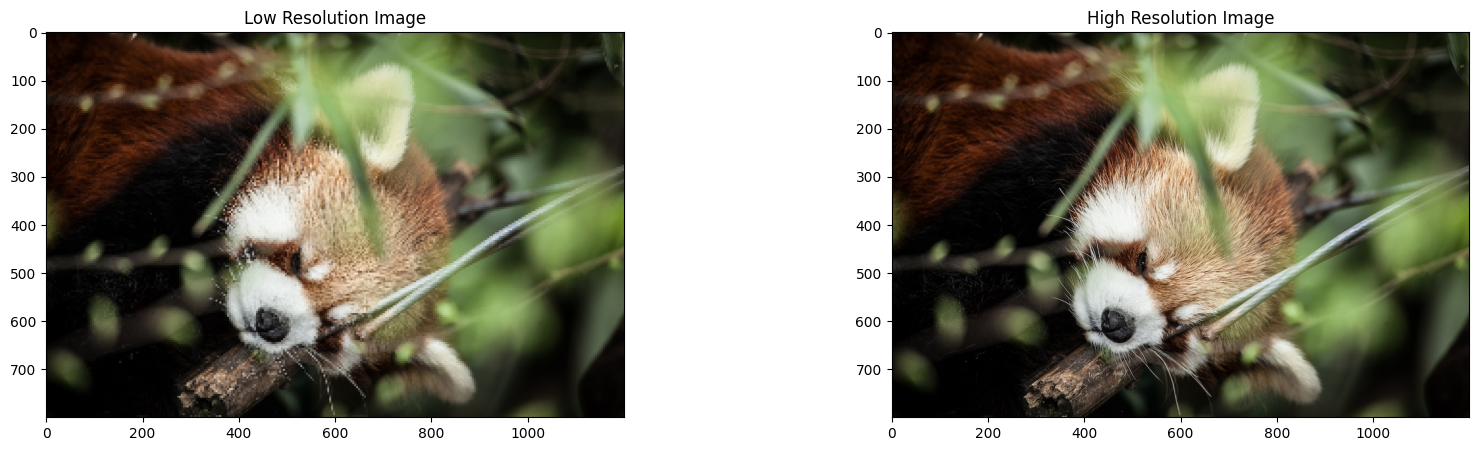

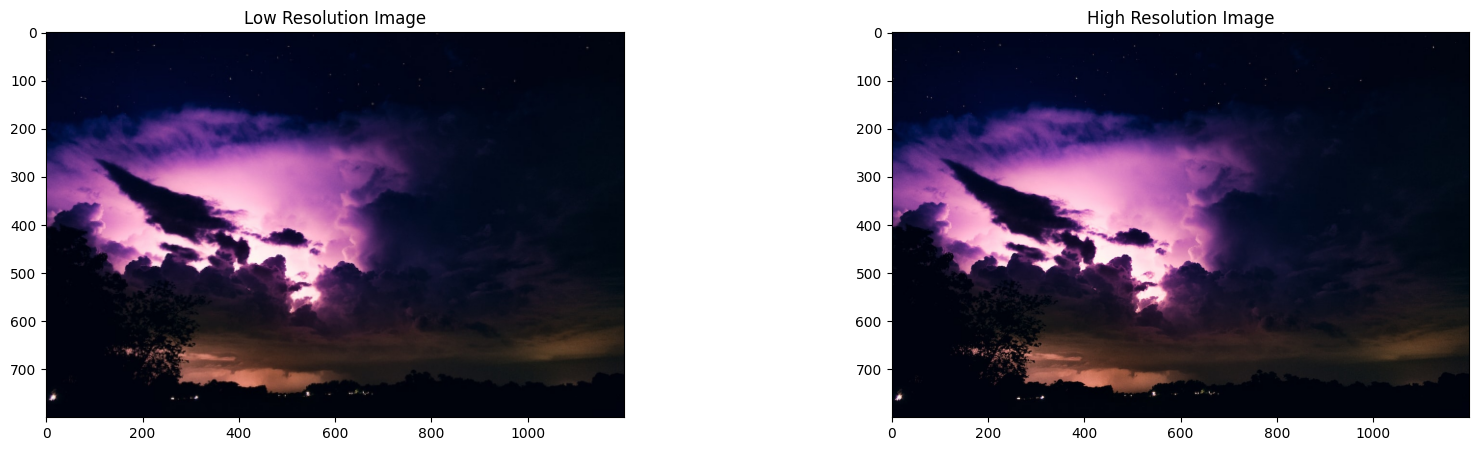

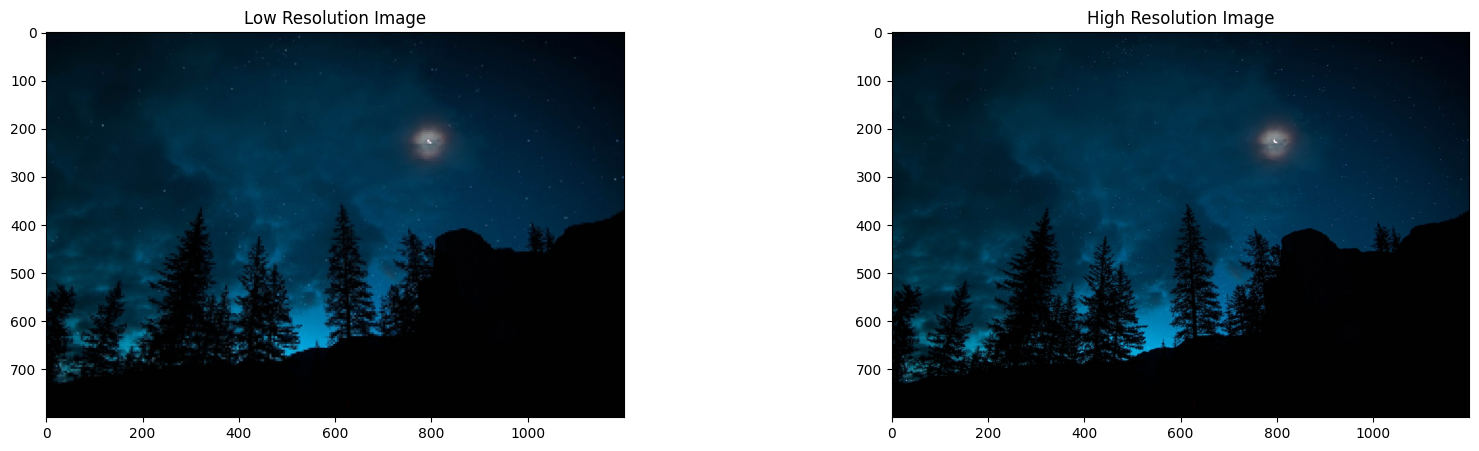

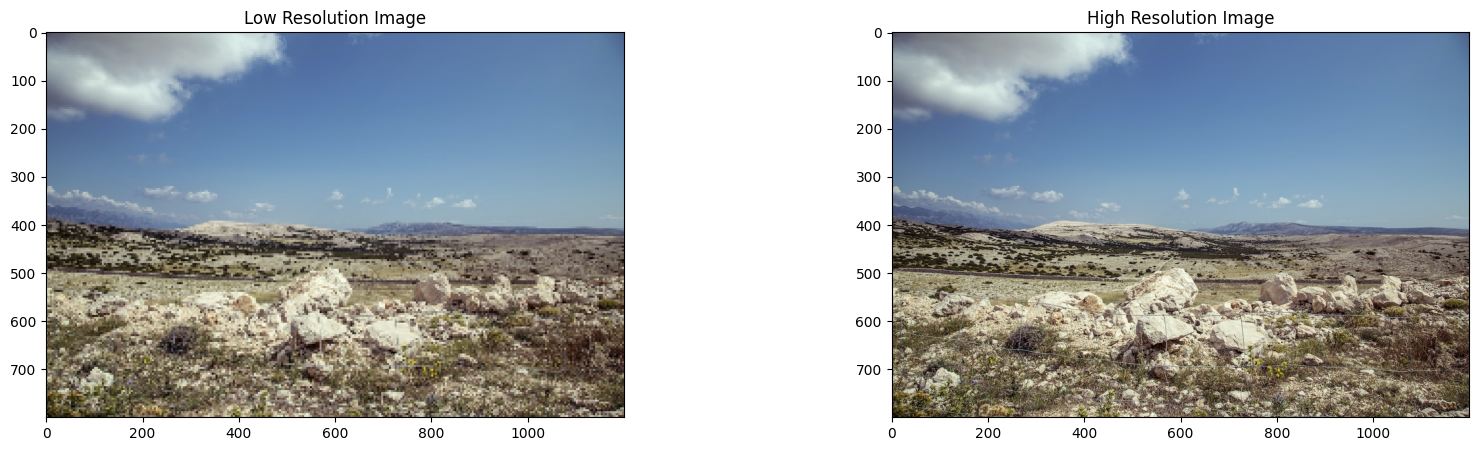

In [15]:
n = 0
for i,m in train_generator:
    img,out = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,5))
        axs[0].imshow(img[0])
        axs[0].set_title('Low Resolution Image')
        axs[1].imshow(out[0])
        axs[1].set_title('High Resolution Image')
        plt.show()
        n+=1
    else:
        break

# Autoencoders


In [16]:
input_img = Input(shape=(800, 1200, 3))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu')(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu')(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu')(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu')(l6)

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu')(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu')(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu')(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu')(l13)

l15 = add([l14, l2])

decoded = Conv2D(3, (3, 3), padding='same', activation='relu')(l15)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

## Reconstruction Loss


In [17]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 800, 1200, 3)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 800, 1200, 64)  │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 800, 1200, 64)  │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 400, 600, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 400, 600, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 400, 600, 128)  │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 400, 600, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 200, 300, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 200, 300, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 400, 600, 256)  │              0 │ conv2d_4[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 400, 600, 128)  │        295,040 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 400, 600, 128)  │        147,584 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 400, 600, 128)  │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 800, 1200, 128) │              0 │ add[0][0]              │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 800, 1200, 64)  │         73,792 │ up_sampling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 800, 1200, 64)  │         36,928 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 800, 1200, 64)  │              0 │ conv2d_8[0][0],        │
│                      

 Total params: 1,110,403 (4.24 MB)

 Trainable params: 1,110,403 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training
<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif'>

In [18]:
train_samples = train_hiresimage_generator.samples
val_samples = val_hiresimage_generator.samples

train_img_gen = imageGenerator(train_generator)
val_image_gen = imageGenerator(val_generator)

In [19]:
model_path = "autoencoder.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 9,
                          verbose = 1,
                          restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
hist = autoencoder.fit(train_img_gen,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=val_image_gen,
                    validation_steps=val_samples//batch_size,
                    epochs=10, callbacks=[earlystop, checkpoint, learning_rate_reduction])

Epoch 1/10


# Inference

## Learning Curves

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Results
- Original Image, Ground Truth Image, Predicted Super Resolution Image

In [ ]:
n = 0
for i,m in val_generator:
    img,mask = i,m
    sr1 = autoencoder.predict(img)
    if n < 20:
        fig, axs = plt.subplots(1 , 3, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Low Resolution Image')
        axs[1].imshow(mask[0])
        axs[1].set_title('High Resolution Image')
        axs[2].imshow(sr1[0])
        axs[2].set_title('Predicted High Resolution Image')
        plt.show()
        n+=1
    else:
        break

<div class='alert alert-success'><strong>Conclusion:</strong>
    <li>The reconstruction loss achieved over here seems to hit a plateau after initial iterations</li>
    <li>Other variations of autoencoders can be used to improve the generation of high resolution images</li>
    <li>Conditional GANs can be used as one of the approaches</li>
</div>